In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plot_tools import plot_groups, plot_input_image
%matplotlib inline
np.random.seed(746519283)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Corners Problem

Binary images containing 8 corner-pieces each. Four of them are arranged in a square, while the other 4 are randomly distributed. Introduced in [1] to investigate binding in deep networks.


In [2]:
width = 28
height = 28

corner = np.zeros((5, 5))
corner[:2, :] = 1.0
corner[:, :2] = 1.0

corners = [
    corner.copy(),
    corner[::-1, :].copy(),
    corner[:, ::-1].copy(),
    corner[::-1, ::-1].copy()
]

square = np.zeros((20, 20))
square[:5, :5] = corners[0]
square[-5:, :5] = corners[1]
square[:5, -5:] = corners[2]
square[-5:, -5:] = corners[3]


In [3]:
def generate_corners_image(width, height, nr_squares=1, nr_corners=4):
    img = np.zeros((height, width))
    grp = np.zeros_like(img)
    k = 1
    
    for i in range(nr_squares):
        x = np.random.randint(0, width-19)
        y = np.random.randint(0, height-19)
        region = (slice(y,y+20), slice(x,x+20))
        img[region][square != 0] += 1
        grp[region][square != 0] = k        
        k += 1
    
    for i in range(nr_corners):
        x = np.random.randint(0, width-4)
        y = np.random.randint(0, height-4)
        corner = corners[np.random.randint(0, 4)]
        region = (slice(y,y+5), slice(x,x+5))
        img[region][corner != 0] += 1
        grp[region][corner != 0] = k
        k += 1
        
    grp[img > 1] = 0
    img = img != 0
    return img, grp
    

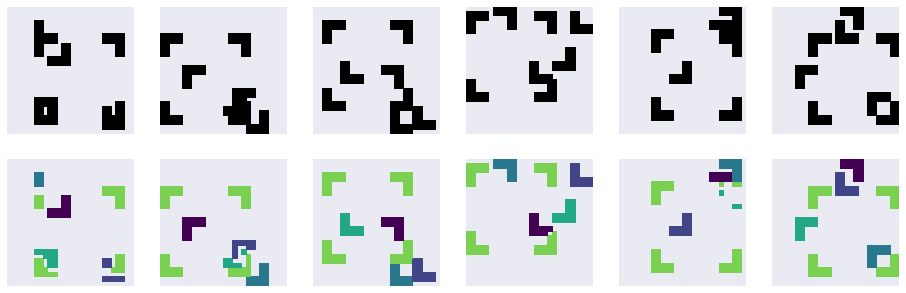

In [4]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(16, 5))
for ax in axes.T:
    img, grp = generate_corners_image(28, 28, 1, 4)
    plot_input_image(img, ax[0])
    plot_groups(grp, ax[1])

# Save as dataset

In [5]:
import h5py
import os
import os.path

data_dir = os.environ.get('BRAINSTORM_DATA_DIR', '.')

In [6]:
nr_train_examples = 60000
nr_test_examples = 10000
nr_single_examples = 5000

width = 28
height = 28
nr_squares = 1
nr_corners = 4

data = np.zeros((1, nr_train_examples, height, width, 1), dtype=np.float32)
grps = np.zeros_like(data)
for i in range(nr_train_examples):
    data[0, i, :, :, 0], grps[0, i, :, :, 0] = generate_corners_image(width, height, nr_squares, nr_corners)
    
data_test = np.zeros((1, nr_test_examples, height, width, 1), dtype=np.float32)
grps_test = np.zeros_like(data_test)
for i in range(nr_test_examples):
    data_test[0, i, :, :, 0], grps_test[0, i, :, :, 0] = generate_corners_image(width, height, nr_squares, 
                                                                                nr_corners)

data_single = np.zeros((1, nr_single_examples, height, width, 1), dtype=np.float32)
grps_single = np.zeros_like(data_single)
for i in range(nr_single_examples // 2):
    data_single[0, i, :, :, 0], grps_single[0, i, :, :, 0] = generate_corners_image(width, height, 1, 0)
for i in range(nr_single_examples // 2, nr_single_examples):
    data_single[0, i, :, :, 0], grps_single[0, i, :, :, 0] = generate_corners_image(width, height, 0, 1)

shuffel_idx = np.arange(nr_single_examples)
np.random.shuffle(shuffel_idx)
data_single = data_single[:, shuffel_idx]
grps_single = grps_single[:, shuffel_idx]

In [7]:
with h5py.File(os.path.join(data_dir, 'corners.h5'), 'w') as f:
    single = f.create_group('train_single')
    single.create_dataset('default', data=data_single, compression='gzip', chunks=(1, 100, height, width, 1))
    single.create_dataset('groups', data=grps_single, compression='gzip', chunks=(1, 100, height, width, 1))
    
    train = f.create_group('train_multi')
    train.create_dataset('default', data=data, compression='gzip', chunks=(1, 100, height, width, 1))
    train.create_dataset('groups', data=grps, compression='gzip', chunks=(1, 100, height, width, 1))
    
    test = f.create_group('test')
    test.create_dataset('default', data=data_test, compression='gzip', chunks=(1, 100, height, width, 1))
    test.create_dataset('groups', data=grps_test, compression='gzip', chunks=(1, 100, height, width, 1))

# References
[1] David P. Reichert and Thomas Serre, [Neuronal Synchrony in Complex-Valued Deep Networks](http://arxiv.org/abs/1312.6115), ICLR 2014

